## StyleGANXL


Source: https://github.com/autonomousvision/stylegan_xl

Source paper: https://arxiv.org/pdf/2202.00273v2.pdf

In [1]:

!git clone https://github.com/autonomousvision/stylegan_xl



Cloning into 'stylegan_xl'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 298 (delta 75), reused 58 (delta 44), pack-reused 192
Receiving objects: 100% (298/298), 13.89 MiB | 29.81 MiB/s, done.
Resolving deltas: 100% (134/134), done.


## Install packages

In [2]:
!pip install timm
!pip install ftfy
!pip install einops ninja


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 7.7 MB/s 


Go to folder.

In [3]:
cd stylegan_xl/

/content/stylegan_xl


## Generate Pokemon images (video)

In [10]:
#!python gen_video.py --output=lerp.mp4 --trunc=0.7 --seeds=0-31 --grid=4x2 \
#  --network=https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl

Loading networks from "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl"...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
100% 480/480 [12:35<00:00,  1.57s/it]


##  Evaluation on Cifar10 test set.

In [4]:
!mkdir raw_data
!mkdir data

Download test set of CIFAR-10.

In [7]:
from torchvision.datasets import CIFAR10
CIFAR10(root='/content/stylegan_xl/raw_data', train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/stylegan_xl/raw_data/cifar-10-python.tar.gz to /content/stylegan_xl/raw_data


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/stylegan_xl/raw_data
    Split: Test

Transform to desired format for the model using dataset_tool.py.

In [10]:
!python dataset_tool.py --source /content/stylegan_xl/raw_data/cifar-10-python.tar.gz --dest /content/stylegan_xl/data/cifar10.zip

100% 50000/50000 [00:13<00:00, 3689.52it/s]


Get metric using pre-trained model on test CIFAR10 set.

In [11]:
!python calc_metrics.py --metrics=fid50k_full --network=https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/cifar10.pkl

Loading network from "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/cifar10.pkl"...
Dataset options:
{
  "class_name": "training.dataset.ImageFolderDataset",
  "path": "./data/cifar10.zip",
  "use_labels": true,
  "max_size": 50000,
  "xflip": false,
  "resolution": 32,
  "random_seed": 0
}
Launching processes...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.

Generator                    Parameters  Buffers  Output shape       Datatype
---                          ---         ---      ---                ---     
mapping.embed                320000      -        [1, 320]           float32 
mapping.embed_proj           20544       -        [1, 64]            float32 
mapping.fc0                  66048       -        [1, 512]           float32 
mapping.fc1                  262656      -        [1, 512]           float32 
mapping                      -           5120     [1, 12, 512]       float32 
sy

## Generate face images using FFHQ1024

In [5]:
!mkdir generated_images

In [6]:
!python gen_images.py --outdir=/content/stylegan_xl/generated_images --trunc=0.7 --seeds=10-15 --batch-sz 1 \
  --network=https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/ffhq1024.pkl

Loading networks from "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/ffhq1024.pkl"...
 done
Generating image for seed 10 (0/6) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for seed 11 (1/6) ...
Generating image for seed 12 (2/6) ...
Generating image for seed 13 (3/6) ...
Generating image for seed 14 (4/6) ...
Generating image for seed 15 (5/6) ...


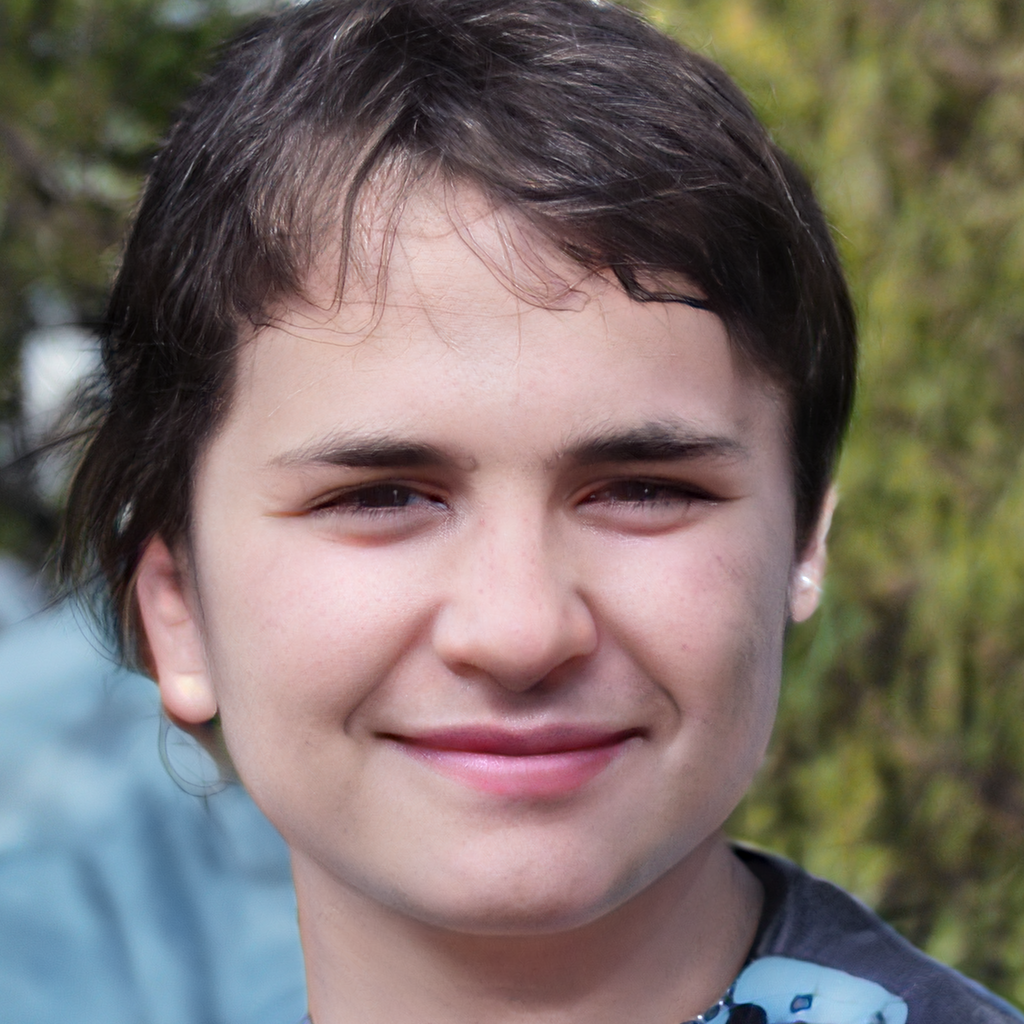

In [7]:
from IPython.display import Image
Image(filename='/content/stylegan_xl/generated_images/seed0010.png') 

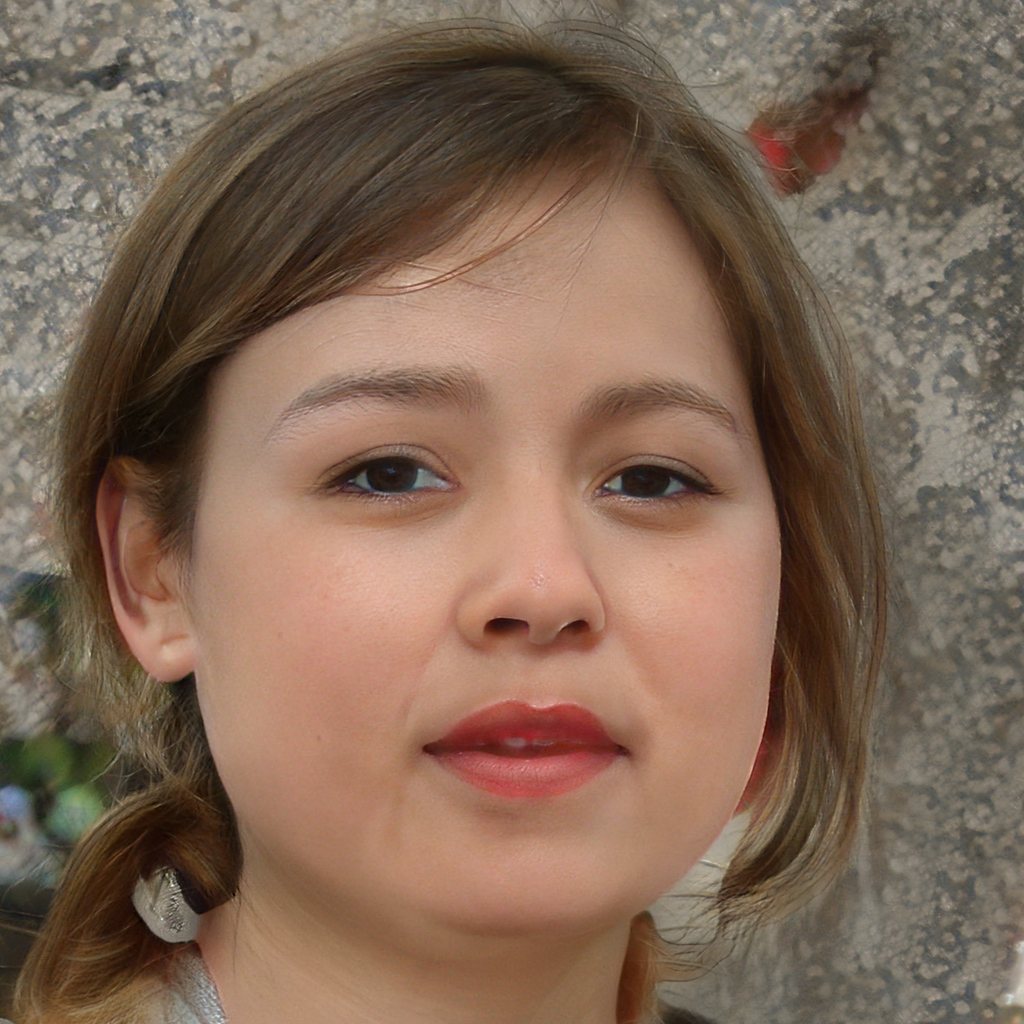

In [8]:
from IPython.display import Image
Image(filename='/content/stylegan_xl/generated_images/seed0011.png') 

## Turn text input to images by combining StyleGAN with CLIP.

Source code: https://colab.research.google.com/github/CasualGANPapers/unconditional-StyleGANXL-CLIP/blob/main/StyleganXL%2BCLIP.ipynb#scrollTo=tAknegrdPM-d

In [18]:
!git clone https://github.com/openai/CLIP
!git clone https://github.com/crowsonkb/esgd.git
!pip install -e ./CLIP

fatal: destination path 'CLIP' already exists and is not an empty directory.
fatal: destination path 'esgd' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/stylegan_xl/CLIP
  Attempting uninstall: clip
    Found existing installation: clip 1.0
    Can't uninstall 'clip'. No files were found to uninstall.
  Running setup.py develop for clip


In [20]:
import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan_xl')
sys.path.append('./esgd')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
from esgd import ESGD
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
import dnnlib
import legacy


device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

# Functions (many must be trimmed too)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    !wget -c '{url_or_path}'

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)  

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/16"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))
  
clip_model = CLIP()

Using device: cuda:0
100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 218MiB/s]


In [24]:


Model = 'Imagenet-1024' 


network_url = {
    "Imagenet-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet1024.pkl",
    "Imagenet-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl",
    "Imagenet-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl",
    "Imagenet-128": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl",
    "Pokemon-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon1024.pkl",
    "Pokemon-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon512.pkl",
    "Pokemon-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl",
    "FFHQ-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/ffhq256.pkl"
}

network_name = network_url[Model].split("/")[-1]
fetch_model([Model])

with dnnlib.util.open_url(network_url[Model]) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


zs = torch.randn([10000, G.mapping.z_dim], device=device)
cs = torch.zeros([10000, G.mapping.c_dim], device=device)
for i in range(cs.shape[0]):
  cs[i,i//10]=1
w_stds = G.mapping(zs, cs)
w_stds = w_stds.reshape(10, 1000, G.num_ws, -1)
w_stds=w_stds.std(0).mean(0)[0]
w_all_classes_avg = G.mapping.w_avg.mean(0)

http://[Imagenet-1024]: Invalid IPv6 numeric address.
Setting up PyTorch plugin "bias_act_plugin"... Done.


You can change text description input here.

Your random seed is: 5450028196


  0%|          | 0/100 [00:00<?, ?it/s]

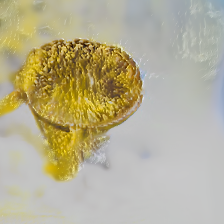

Image 0/100 | Current loss: 0.8408818244934082


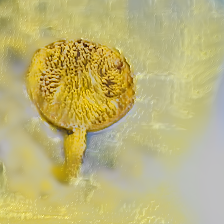

Image 10/100 | Current loss: 0.7387063503265381


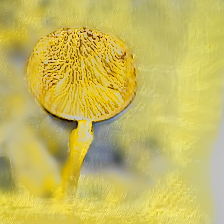

Image 20/100 | Current loss: 0.7117956876754761


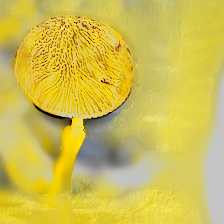

Image 30/100 | Current loss: 0.7083905339241028


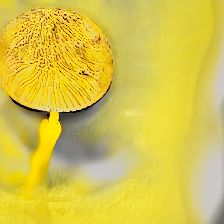

Image 40/100 | Current loss: 0.7491896748542786


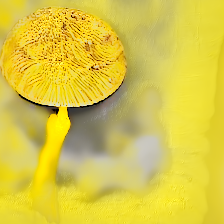

Image 50/100 | Current loss: 0.6877460479736328


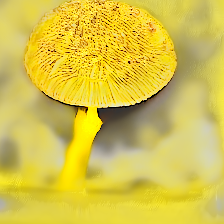

Image 60/100 | Current loss: 0.6997002363204956


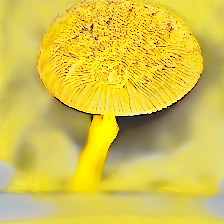

Image 70/100 | Current loss: 0.6875373125076294


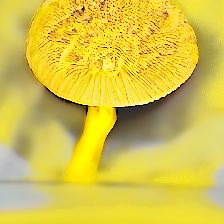

Image 80/100 | Current loss: 0.6837170124053955


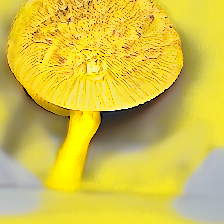

Image 90/100 | Current loss: 0.6916579008102417


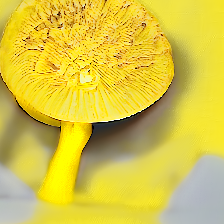

Image 99/100 | Current loss: 0.6806979775428772


In [27]:


texts = "yellow mushroom"
steps = 100
seed = -1

if seed == -1:
    seed = np.random.randint(0,9e9)
    print(f"Your random seed is: {seed}")

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]


'''
zs = torch.randn([10000, G.mapping.z_dim], device=device)
one_hot_class = torch.zeros(1000)
initial_class = torch.randint(0,1000, (1,))[0]
one_hot_class[initial_class]=1
one_hot_class = one_hot_class.repeat((10000, 1))
cs = one_hot_class.to(device)
w_stds = G.mapping(zs, cs)
w_stds=w_stds.std(0)[0]
'''




tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

initial_batch=4 #actually that will be multiplied by initial_image_steps
initial_image_steps=16
'''
c = torch.zeros((1000)) #just to pick a closer initial image
c[initial_class]=1
c = c.repeat(initial_batch, 1)
c=c.to(device)
'''
def run(timestring):
  torch.manual_seed(seed)
  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(initial_image_steps):
      a = torch.randn([initial_batch, 512], device=device)*0.6 + w_all_classes_avg*0.4
      q = ((a-w_all_classes_avg)/w_stds)
      images = G.synthesis((q * w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]))
      embeds = embed_image(images.add(1).div(2))
      loss = prompts_dist_loss(embeds, targets, spherical_dist_loss).mean(0)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss[i])
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).repeat([G.num_ws, 1]).requires_grad_()
    # print(q)
    # q = qs[i].unsqueeze(0).repeat([G.num_ws, 1])
    # q = torch.tensor(q, requires_grad=True)
    # print(q)


  # Sampling loop
  q_ema = q
  # print(q.shape)
  # opt = ESGD([q], lr=0.03, betas=(0.9, 0.999), nu=0.9)
  opt = torch.optim.AdamW([q], lr=0.03, betas=(0., 0.999), weight_decay=0.025)
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis((q * w_stds + w_all_classes_avg)[None], noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()
    # loss.backward(create_graph=opt.should_create_graph())
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.95 + q * 0.05
    image = G.synthesis((q_ema * w_stds + w_all_classes_avg)[None], noise_mode='const')

    if i % 10 == 0 or i == (steps - 1):
      display(TF.to_pil_image(tf(image)[0]))
      print(f"Image {i}/{steps} | Current loss: {loss}")
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(f'samples/{timestring}', exist_ok=True)
    pil_image.save(f'samples/{timestring}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring)
except KeyboardInterrupt:
  pass